In [1]:
pwd

'/private/home/dpf/projects/htlm_2/fairseq-py/notebooks'

In [2]:
pwd

'/private/home/dpf/projects/htlm_2/fairseq-py/notebooks'

In [3]:
temperature = 0.8
root_folder = f'/private/home/dpf/projects/codex/'
globs = f'out/cm-6B_it-best_ncg-20-1_temp-{temperature}/prompt-pyfile_s-*/responses.pkl'

In [4]:
import sys

In [5]:
sys.path.append(root_folder)

In [6]:
import glob
import pickle
import os

In [7]:
from models import Model

couldn't import torch; won't be able to use most models


In [8]:
import numpy as np

In [9]:
from human_eval.data import read_problems
from human_eval.evaluation import evaluate_functional_correctness

In [10]:
def unpickle(fname):
    print(fname)
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [11]:
def all_equal(xs):
    xs = list(xs)
    return [x == xs[0] for x in xs]

In [12]:
def combine_responses(list_of_responses):
    list_of_responses = list(list_of_responses)
    assert all_equal(resp.keys() for resp in list_of_responses)
    responses = {}
    for resp in list_of_responses:
        for problem_id in resp:
            if problem_id not in responses:
                responses[problem_id] = {'choices': []}
            responses[problem_id]['choices'].extend(resp[problem_id]['choices'])
    return responses

In [13]:
pdb on

Automatic pdb calling has been turned ON


In [14]:
responses = combine_responses(
    unpickle(fname) for fname in glob.glob(os.path.join(root_folder, globs))
)

/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-3/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-4/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-10/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-5/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-6/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-7/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-8/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-1/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-9/responses.pkl
/private/home/dpf/projects/codex/out/cm-6B_it-best_ncg-20-1_temp-0.8/prompt-pyfile_s-2/res

In [15]:
len(next(iter(responses.values()))['choices'])

200

In [16]:
len(next(iter(responses.values()))['choices'])

200

In [17]:
model = Model()

In [18]:
problems = list(sorted(read_problems().items()))

In [19]:
import random

In [20]:
def run_trial(responses, num_candidates, candidate_scoring):
    samples_to_evaluate = []
    for task_id, problem in problems:
        candidates = responses[task_id]['choices'].copy()
        random.shuffle(candidates)
        candidates = candidates[:num_candidates]
        completions, response = model.rank_completions(
            problem['prompt'], None, 
            cached_response={'choices': candidates},
            scoring=candidate_scoring,
        )
        best_score, best_candidate = completions[0]
        samples_to_evaluate.append(dict(
            task_id=task_id,
            completion=best_candidate
        ))
    return evaluate_functional_correctness(
        sample_file=None, samples=samples_to_evaluate,
        n_workers=4, suppress=True,
    )

In [21]:
def compute_oracle_scores(responses, all_num_candidates):
    samples_to_evaluate = []
    for task_id, problem in problems:
        choices = responses[task_id]['choices']
        assert max(all_num_candidates) <= len(choices), f"can't compute oracle; too few candidates ({len(choices)}) for id {task_id}"
        for choice in choices:
            samples_to_evaluate.append(dict(
                task_id=task_id, 
                completion=choice['text']
            ))
    results, extra = evaluate_functional_correctness(
        sample_file=None, samples=samples_to_evaluate,
        n_workers=20, suppress=False,
    )
    datapoints = []
    for num_candidates in all_num_candidates:
        datapoints.append({
            'num_candidates': num_candidates,
            'candidate_scoring': 'oracle',
            'pass@1': results[f'pass@{num_candidates}'],
        })
    return datapoints

In [22]:
datapoints = compute_oracle_scores(responses, [1, 10, 100])

100%|███████████████████████████████████████████████████████████████████████████████████████| 32800/32800 [00:02<00:00, 16308.82it/s]


Running test suites...


100%|██████████████████████████████████████████████████████████████████████████████████████████| 32800/32800 [13:26<00:00, 40.69it/s]


In [23]:
# all_num_candidates = list(np.arange(9) + 1) + list((np.arange(10) + 1) * 10)
#all_num_candidates = [1, 10, 100]
all_num_candidates = [1, 2, 5, 10, 20, 50, 100]
all_num_candidates

[1, 2, 5, 10, 20, 50, 100]

In [24]:
from itertools import product

In [30]:
all_extras = {}
def log_trial(tpl):
    scoring_method, num_candidates, trial = tpl
    result, extras = run_trial(responses, num_candidates, scoring_method)
    result['num_candidates'] = num_candidates
    result['candidate_scoring'] = scoring_method
    result['trial'] = trial
    all_extras[tuple(tpl)] = extras
    return result

scoring_methods = ['sum', 'mean', 'random']
trials = list(range(3))

from multiprocessing.pool import ThreadPool
import tqdm
with ThreadPool(5) as pool:
    it = list(product(scoring_methods, all_num_candidates, trials))
    results = tqdm.tqdm(pool.imap(log_trial, it), total=len(it))
    datapoints.extend(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [04:42<00:00,  4.48s/it]


In [31]:
import pandas

In [32]:
df = pandas.DataFrame(datapoints)

In [33]:
df.columns

Index(['num_candidates', 'candidate_scoring', 'pass@1', 'trial'], dtype='object')

In [34]:
means = df.groupby(['num_candidates','candidate_scoring'])['pass@1'].mean()

In [35]:
import matplotlib.pyplot as plt

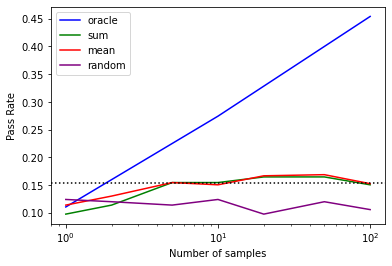

In [38]:
r = means.reset_index()
ax = None
for scoring, color in [('oracle', 'b'), ('sum', 'g'), ('mean', 'r'), ('random', 'purple')]:
    col = r[r['candidate_scoring'] == scoring]
    ax = col.plot(
        x='num_candidates', y='pass@1', color=color, label=scoring, logx=True,
        ax=ax,
    )
plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Pass Rate')
plt.axhline(0.153, c='k', linestyle=':')

In [48]:
from collections import defaultdict

In [46]:
def pool_by_problem(all_extras, filter_fn=None):
    completion_lengths_by_problem = defaultdict(list)
    for tpl, d in all_extras.items():
        if filter_fn is not None and not filter_fn(tpl):
            continue
        for k, vs in d['completion_lengths'].items():
            completion_lengths_by_problem[k].extend(vs)
    return completion_lengths_by_problem

In [52]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras).items()}.values()))

312.78290747193194

In [56]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'random' and t[1] == 100).items()}.values()))

315.7073170731707

In [57]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'sum' and t[1] == 100).items()}.values()))

69.90650406504065

In [58]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'mean' and t[1] == 100).items()}.values()))

728.3983739837398